<a href="https://colab.research.google.com/github/WilmarAriza/Securitization/blob/main/CanadianZeros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Canadian Treasury Yield Curve Bootstrapping***

This project aims to 'bootstrapp' the on-the-run Canadian Treasury curve to find the Zero curve. Later on, this curve will bring back the cash-flows of MBS generated by a Montecarlo simulation. The whole idea is to build a first level model to value MBS.

MBS valuation is extremelly complicated due to the implied uncertainty in both the volatility of the interest rates and the prepayment cash-flows.

As a starting point this module interpolates the yield curve, standarizes the cash flows and bootstrapps into Zeros using Python.


***Bonds***

In general, there are two parameters that are needed to describe fully the cash flows on a bond. The first is the maturity date of the bond, at which time the principal, or face amount of the bond is paid and the bond retired. The second parameter need to describe a bond is the coupon rate. A Government of Canada bond issued in the domestic market pays one-half of its coupon rate times its principal value every six months up to and including the maturity date. Thus, a bond with an 8 per cent coupon maturing on December 1, 2005 will make future coupon payments of 4 per cent of principal value on each June 1 and December 1 between the purchase date and the maturity date.

The price of the bond is found by discounting future cash flows back to their present value as indicated in the following formula:
In other words, the price equals the sum of each cash flow at a period N, that is divided by a discount rate, which is the yield to maturity divided by 200, plus 1, and to the power N.

where

P = current price

N = number of semi-annual periods

y = yield to maturity (expressed in percentage points). The yield is divided by 200 to convert the yield to a percentage on a semi-annual basis.

CF = cash flow in a given semi-annual period (coupon⁄2) and at maturity (coupon⁄2) + 100


**Coupon**

Bond prices are quoted as a percentage of the bond's par or face value and exclude accrued interest; e.g. if a nominal fixed coupon bond is quoted as 101.59, then the price of that bond is 101.59% or 1.0159 times the value of the bond at maturity.

When an investor buys a bond between coupon payments, the investor must compensate the seller of the bond for the coupon interest earned from the time of the last coupon payment to the settlement date of the bond. This amount is called accrued interest. Accrued interest for Government of Canada bonds are calculated as follows:
C/2 		actual number of days from the last coupon payment to settlement date
actual number of days in coupon period

where C = coupon payment

The market convention for calculating accrued interest on Government of Canada bonds is known as actual over 365 basis, which considers a year to have 365 days.

Load data

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

import scipy.interpolate
import pandas as pd
import numpy as np

url = 'https://raw.githubusercontent.com/WilmarAriza/Securitization/main/can_gov_bench.csv'

bonds = pd.read_csv(url, header=2, parse_dates=['Maturity'])
bonds

,Series,2022-04-28,2022-04-29,2022-05-02,2022-05-03,2022-05-04,Year,Month,Day,Maturity,ISIN,Outstanding Amount,Unnamed: 12
0,Treasury Bills,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
1,1 month,NaN,NaN,NaN,NaN,0.92,2022.0,6.0,23.0,2022-06-23,CA1350Z7AG92,"17,400,000,000",NaN
2,3 month,NaN,NaN,NaN,NaN,1.41,2022.0,8.0,4.0,2022-08-04,CA1350Z7AX26,"15,000,000,000",NaN
3,6 month,NaN,NaN,NaN,NaN,1.99,2022.0,11.0,10.0,2022-11-10,CA1350Z7AS31,"6,200,000,000",NaN
4,1 year,NaN,NaN,NaN,NaN,2.40,2023.0,4.0,27.0,2023-04-27,CA1350Z7A613,"3,200,000,000",NaN
5,Benchmark bond yields,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
6,2 year,2.53,2.63,2.66,2.71,2.61,2024.0,2.0,1.0,2024-02-01,NaN,NaN,NaN
7,3 year,2.58,2.67,2.70,2.76,2.65,2024.0,10.0,1.0,2024-10-01,NaN,NaN,NaN
8,5 year,2.66,2.75,2.81,2.84,2.74,2027.0,3.0,1.0,2027-03-01,NaN,NaN,NaN
9,7 year,2.66,2.75,2.81,2.84,2.75,2028.0,6.0,1.0,2028-06-01,NaN,NaN,NaN


Time to maturity

In [33]:
current_date = pd.datetime(2022, 5, 4)
ttm = [(maturity - current_date).days / 365 for maturity in bonds['Maturity']]
bonds['Time to Maturity'] = ttm # ttm in years
bonds['2022-05-04'] /=100 # Yields in %
bonds

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


,Series,2022-04-28,2022-04-29,2022-05-02,2022-05-03,2022-05-04,Year,Month,Day,Maturity,ISIN,Outstanding Amount,Unnamed: 12,Time to Maturity
0,Treasury Bills,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
1,1 month,NaN,NaN,NaN,NaN,0.0092,2022.0,6.0,23.0,2022-06-23,CA1350Z7AG92,"17,400,000,000",NaN,0.136986
2,3 month,NaN,NaN,NaN,NaN,0.0141,2022.0,8.0,4.0,2022-08-04,CA1350Z7AX26,"15,000,000,000",NaN,0.252055
3,6 month,NaN,NaN,NaN,NaN,0.0199,2022.0,11.0,10.0,2022-11-10,CA1350Z7AS31,"6,200,000,000",NaN,0.520548
4,1 year,NaN,NaN,NaN,NaN,0.0240,2023.0,4.0,27.0,2023-04-27,CA1350Z7A613,"3,200,000,000",NaN,0.980822
5,Benchmark bond yields,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
6,2 year,2.53,2.63,2.66,2.71,0.0261,2024.0,2.0,1.0,2024-02-01,NaN,NaN,NaN,1.747945
7,3 year,2.58,2.67,2.70,2.76,0.0265,2024.0,10.0,1.0,2024-10-01,NaN,NaN,NaN,2.413699
8,5 year,2.66,2.75,2.81,2.84,0.0274,2027.0,3.0,1.0,2027-03-01,NaN,NaN,NaN,4.827397
9,7 year,2.66,2.75,2.81,2.84,0.0275,2028.0,6.0,1.0,2028-06-01,NaN,NaN,NaN,6.082192


Interpolation

THis process finds yields for nodes 0.5Y, 1.0Y, 1.5Y, ..., 30.0Y

In [34]:
p = list(i for i in range(1, 60))
y = []
interp = scipy.interpolate.interp1d(bonds['Time to Maturity'], bonds['2022-05-04'], bounds_error=False, fill_value=scipy.nan)
for i in p: # Interpolation inside the short and the long end bonds
    value = float(interp(i*0.5))
    if not scipy.isnan(value):
        y.append(value)
y

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: scipy.isnan is deprecated and will be removed in SciPy 2.0.0, use numpy.isnan instead
  


[0.019456122448979592,
 0.0240525,
 0.02542125,
 0.026251440329218105,
 0.026532179341657205,
 0.02671861520998865,
 0.02690505107832009,
 0.027091486946651533,
 0.027277922814982973,
 0.027413755458515286,
 0.027453602620087336,
 0.02749344978165939,
 0.02767899061032864,
 0.02789319248826291,
 0.02810739436619718,
 0.028321596244131456,
 0.028535798122065727,
 0.028749999999999998,
 0.02896420187793427,
 0.028991676933607116,
 0.028981683778234086,
 0.028971690622861052,
 0.02896169746748802,
 0.02895170431211499,
 0.028941711156741955,
 0.028931718001368924,
 0.02892172484599589,
 0.02891173169062286,
 0.028901738535249827,
 0.028891745379876797,
 0.028881752224503763,
 0.028871759069130733,
 0.0288617659137577,
 0.028851772758384665,
 0.028841779603011635,
 0.0288317864476386,
 0.02882179329226557,
 0.028811800136892537,
 0.028801806981519507,
 0.028791813826146474,
 0.028781820670773443,
 0.02877182751540041,
 0.02876183436002738,
 0.028751841204654346,
 0.028741848049281312,
 0.0

Bootstrapping

Notice that for a par bond: yield = coupon, therefore in creating the Zero nodes (0.5Y, 1.0Y, ...), starts with the first bond (0.5Y) where yield = Zero rate, and move into the next using the first Zero to fin the next Zero rate, and keep propragating the Zero curve to the last bond.

In [35]:
s = []  # Spot rates
for i in range(0, len(p)):  # Bootstrapping per each spot rate
    sum = 0
    for j in range(0, i):
        sum += y[i]*0.5 / (1 + s[j]*0.5) ** p[j]
    value = (((1 + y[i]*0.5) / (1 - sum)) ** (1 / p[i]) - 1)*2
    s.append(value)
s

[0.019456122448979762,
 0.024080202068208045,
 0.025458296700332284,
 0.02629668129369911,
 0.026576335532012774,
 0.026762031907618944,
 0.02695024738122287,
 0.02714042381231696,
 0.02733226515436682,
 0.02747163665571062,
 0.027509161494612133,
 0.027547621125217248,
 0.02774562201493902,
 0.027976201424821934,
 0.028208027895933352,
 0.028441180865937277,
 0.02867573398928247,
 0.028911757290924545,
 0.029149318672139213,
 0.029171894122391517,
 0.029151648864143898,
 0.02913217571592419,
 0.02911336565630629,
 0.029095127735050408,
 0.029077385457801697,
 0.029060074005119674,
 0.029043138069518637,
 0.029026530156019525,
 0.029010209234315187,
 0.028994139660519114,
 0.02897829030760901,
 0.028962633858917286,
 0.02894714623008543,
 0.028931806093027035,
 0.028916594481501523,
 0.028901494462427735,
 0.0288864908605011,
 0.028871570026296034,
 0.02885671964004466,
 0.028841928544854678,
 0.02882718660433481,
 0.02881248458056307,
 0.02879781402908632,
 0.02878316720823859,
 0.028

**Plotting**

This exhibit shows the on-the-run curve for Canadian Gov. Bonds, the Zero curve calculated using this code, and the Zeros extracted from the website: https://www.bankofcanada.ca/rates/interest-rates/bond-yield-curves/

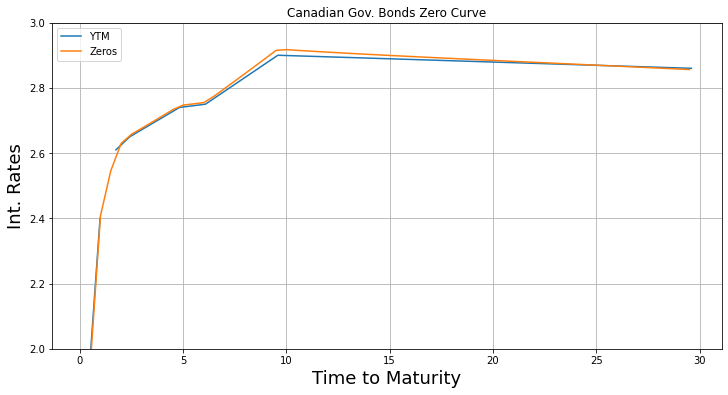

In [36]:
fig, ax = plt.subplots(figsize=(12,6))


ax.plot(bonds['Time to Maturity'], bonds['2022-05-04']*100, label='YTM')
ax.plot(np.array(p)*0.5, np.array(s)*100, label='Zeros')
ax.legend(loc=2) # upper left corner
ax.set_xlabel('Time to Maturity', fontsize=18)
ax.set_ylabel('Int. Rates', fontsize=18)
ax.set_title('Canadian Gov. Bonds Zero Curve')
ax.grid(True)
ax.set_ylim([2.00, 3.00]);